**THIS NOTEBOOK CONSISTS THE CODE FOR SIFT+SVM, HOG+MLP, HOG+SVM**

Setting up Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing the OpenCV

In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 50 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Checking the version of OpenCV

In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


Path for the code folder

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_CODE = 'Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/Code' 
GOOGLE_DRIVE_PATH_CODE = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_CODE)
print(os.listdir(GOOGLE_DRIVE_PATH_CODE))

['Copy of 200033033 Computer Vision Coursework.ipynb', 'Copy of Untitled6.ipynb', 'CNN.ipynb', '200033033 Computer Vision Coursework.ipynb']


Path for the Dataset folder

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_DATA = 'Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Folder_PG/CW_Dataset' 
GOOGLE_DRIVE_PATH_DATA = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE_DATA)
print(os.listdir(GOOGLE_DRIVE_PATH_DATA))

['CW_Dataset.zip']


Coping and unziping the data directly in Colab server. This makes accessing the data faster.

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH_DATA, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

Importing the necessary libraries

In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline

Creating a function to load the data

In [ ]:
# Reference: modified from Lab 7
def import_dataset(path):
    """Load images and labels from selected directories"""
    images = []
    labels = []
    
# for labels
    label_file = open("labels/list_label_" + path + ".txt", "r") # reading the text files from the path
    labels_num = [name.split(' ')[1][0] for name in label_file] # Slicing off the class number to create a list of all the classes

    for num in range(len(labels_num)):
      if labels_num[num] == '1':
        labels.append('Suprise')
      elif labels_num[num] == '2':
        labels.append('Fear')
      elif labels_num[num] == '3':
        labels.append('Disgust')
      elif labels_num[num] == '4':
        labels.append('Happiness')
      elif labels_num[num] == '5':
        labels.append('Sadness')
      elif labels_num[num] == '6':
        labels.append('Anger')
      else:
        labels.append('Neutral')
# for images
    img_file = [file for file in sorted(os.listdir(os.path.join(path))) if file.endswith('.jpg')] # locate the .jpg files in the path
    for file in img_file:
        images.append(io.imread(os.path.join(path, file))) # append the images in the list to create a list of arrays

    return images, labels

#Label explanation:
# 1: Surprise
# 2: Fear
# 3: Disgust
# 4: Happiness
# 5: Sadness
# 6: Anger
# 7: Neutral

Loading the test and train data

In [ ]:
X_train, y_train = import_dataset ('train')

In [ ]:
print(X_train[0].shape)

(100, 100, 3)


In [ ]:
len(X_train)

12271

In [ ]:
len(y_train)

12271

In [ ]:
X_train[0];

In [ ]:
X_test, y_test = import_dataset ('test')

In [ ]:
print(len(y_test))

3068


In [ ]:
print(len(X_test))

3068


In [ ]:
print(Counter(y_train))

Counter({'Happiness': 4772, 'Neutral': 2524, 'Sadness': 1982, 'Suprise': 1290, 'Disgust': 717, 'Anger': 705, 'Fear': 281})


Visualizing the class imbalance of the train data.

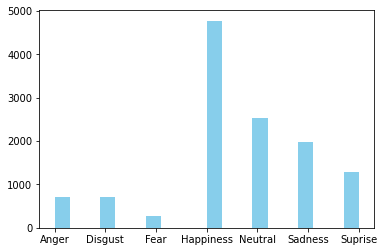

In [ ]:
plt.hist(sorted(y_train), color = "skyblue", bins = 20);
# plt.xlabel("Classes")
plt.show()

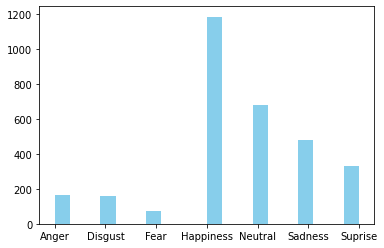

In [ ]:
plt.hist(sorted(y_test), color = "skyblue", bins = 20);
# plt.xlabel("Classes")
plt.show()

**SIFT Feature Descriptor**

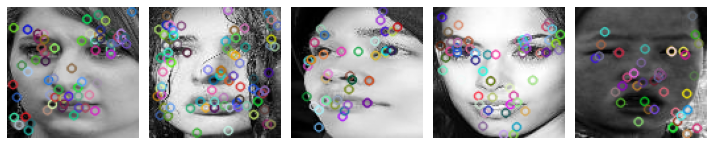

In [ ]:
#Reference - Lab 7

sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
sift_list = []
y_train_list = []

fig, ax = plt.subplots(1, 5, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, desp = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<5:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if desp is not None:
        sift_list.append(desp)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

In [ ]:
len(y_train_list)

12264

In [ ]:
# Reference - lab 7
# Convert to array for easier handling
sift_array = np.vstack(sift_list)

In [ ]:
# Reference - Lab 7
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = sift_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(sift_array)

In [ ]:
# Reference - Lab 7
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in sift_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

**Support Vector machine**

Creating the baseline model in SVM

In [ ]:
classifier = svm.SVC(class_weight= 'balanced') # class_weight is used to handle the class imbalance

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC(class_weight='balanced')

Checking the cross validation score using 5-folds.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
scores_svm = cross_val_score(classifier,hist_array, y_train_list, cv=5)
scores_svm

array([0.31227069, 0.31471667, 0.3110477 , 0.30615573, 0.31769984])

In [ ]:
scores_svm.mean()

0.3123781247319093

Running Grid Search to identify the best parameters for hyper-parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
random_state = 1 
param_grid_k = {'kernel': ['rbf', 'linear','poly'], 'C': [0.1,1,10,100], 'gamma': [0.0001,0.001, 0.1,1] }
grid = GridSearchCV(SVC(), param_grid_k, refit = True, verbose = 3)
 
# fitting the model for grid search
%time grid.fit(hist_array, y_train_list)
best_kernel = grid.best_params_
print(best_kernel)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.389 total time=  12.4s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.389 total time=  11.8s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.389 total time=  11.8s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.389 total time=  11.8s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.389 total time=  11.8s
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.389 total time=   7.8s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.389 total time=   7.7s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.389 total time=   8.1s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.389 total time=   8.6s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.389 total time=   7.9s
[CV 1/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.389 total time=   7.7s
[CV 2/5] END ..C=0.1, gamma=0.0001, kernel=poly

As per the Grid Search, the parameters are: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
from sklearn.svm import SVC
classifier_grid = SVC(kernel = 'rbf', C = 100, gamma = 1, class_weight= 'balanced')

# We learn the digits on the first half of the digits
classifier_grid.fit(hist_array, y_train_list)

SVC(C=100, class_weight='balanced', gamma=1)

In [ ]:
from sklearn.model_selection import cross_val_score
scores_svm_grid = cross_val_score(classifier_grid,hist_array, y_train_list, cv=5)
scores_svm_grid

array([0.27191194, 0.26661231, 0.27395026, 0.26742764, 0.27161501])

In [ ]:
scores_svm_grid.mean()

0.27030343375525123

With grid search the cross validation accuracy has even more decreased. So, the baseline model is considered as the final model.

Predicting the test results using test data

In [ ]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test_sift = [y_test[i] for i in idx_not_empty]
hist_array_test = np.vstack(hist_list)

In [ ]:
y_Pred_SS = classifier.predict(hist_array_test).tolist()

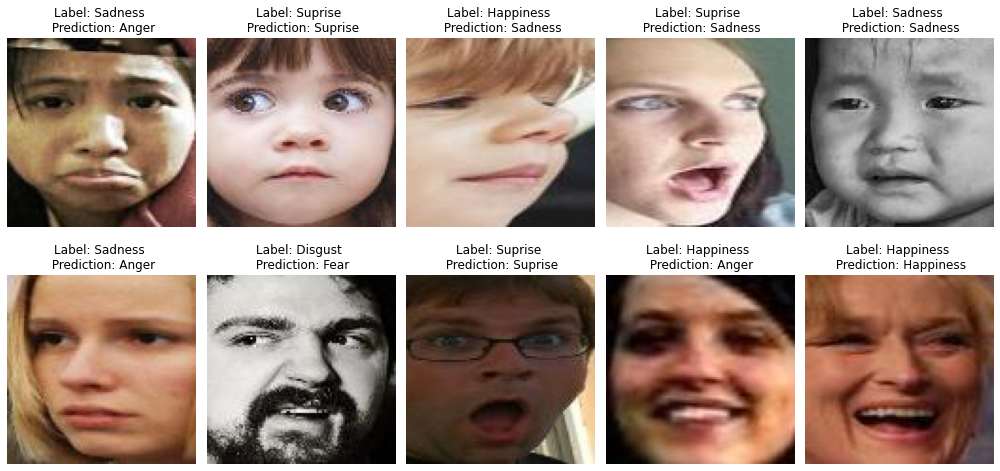

In [ ]:
#Reference - Lab 7
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_Pred_SS[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

SIFT+SVM - turned out to be a very bad classifier as most of the classes are incorectly labeled

Displaying the metrics of the final model

In [ ]:
from sklearn.metrics import classification_report
print(f"""Classification report for classifier SIFT+SVM:
      {metrics.classification_report(y_test_sift, y_Pred_SS)}\n""")

Classification report for classifier SIFT+SVM:
                    precision    recall  f1-score   support

       Anger       0.13      0.31      0.18       162
     Disgust       0.09      0.18      0.12       160
        Fear       0.13      0.30      0.18        74
   Happiness       0.64      0.37      0.47      1184
     Neutral       0.35      0.34      0.35       679
     Sadness       0.26      0.21      0.23       478
     Suprise       0.27      0.37      0.31       329

    accuracy                           0.32      3066
   macro avg       0.27      0.30      0.26      3066
weighted avg       0.41      0.32      0.35      3066




In [ ]:
with open ('Model_SIFT_SVM.pickle', 'wb') as f:
    pickle.dump(classifier, f)

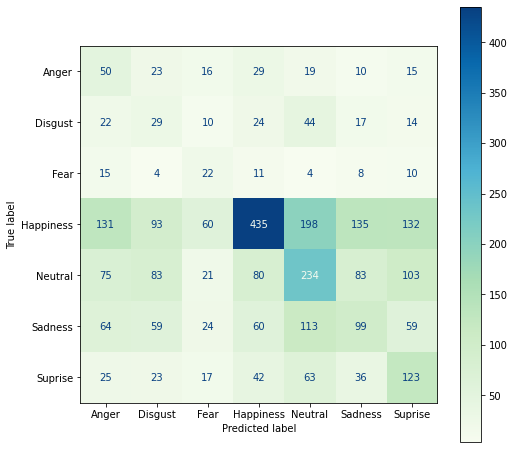

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8, 8))
metrics.ConfusionMatrixDisplay.from_predictions(y_test_sift, y_Pred_SS, cmap = 'GnBu', ax=ax)
plt.show()

In [ ]:
import pickle

In [ ]:
# from sklearn.metrics import roc_curve,roc_auc_score,auc
# roc_auc_score(y_test, y_Pred_SS)

In [ ]:
SVM_FP, SVM_TP, SVM_thresh = roc_curve(y_test, y_Pred_SS)

In [ ]:
SVM_AUC = auc(SVM_FP, SVM_TP)

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(SVM_FP, SVM_TP, color = "teal", label = "ROC curve (area = %0.2f)" % SVM_AUC)
plt.plot([0,1], [0,1], color = "navy", linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC for SVM")
plt.legend(loc = "lower right")
plt.show()

**HOG - Histogram of Oriented Gradients**

In [ ]:
# Reference - Lab - 6 and https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features/notebook
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt

# Create empty lists for feature descriptors and labels
hog_images = []
hog_features = []
ppc = 16

for image in range(len(X_train)):
    
    img = img_as_ubyte(color.rgb2gray(X_train[image]))
    fd, hog_image = hog( img, orientations=8, pixels_per_cell=(ppc, ppc),  cells_per_block=(1, 1), visualize=True)
    
    hog_images.append(hog_image)
    hog_features.append(fd)


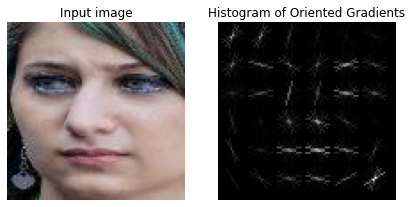

In [ ]:
# Reference - lab 6
fig, ax = plt.subplots(1, 2, figsize=(6, 6), sharex=True, sharey=True)

ax[0].axis('off')
ax[0].imshow(X_train[0])
ax[0].set_title('Input image')

# Rescale histogram for better display
#HOG_image_rescaled = exposure.rescale_intensity(hog_image[0], in_range=(0, 10))

ax[1].axis('off')
ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title('Histogram of Oriented Gradients')
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [ ]:
Classifier_MLP_hog = MLPClassifier(random_state=1, max_iter=100 )
%time Classifier_MLP_hog.fit(hog_features, y_train)

CPU times: user 24.3 s, sys: 21 s, total: 45.3 s
Wall time: 23.9 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(max_iter=100, random_state=1)

In [ ]:
scores_mlp_hog = cross_val_score(Classifier_MLP_hog,hog_features, y_train, cv=5)
scores_mlp_hog

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

array([0.61995927, 0.62102689, 0.60839446, 0.59413203, 0.56968215])

In [ ]:
scores_mlp_hog.mean()

0.602638960124955

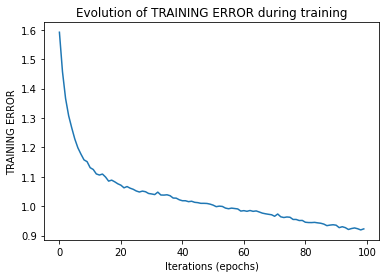

In [ ]:
plt.title("Evolution of TRAINING ERROR during training")
plt.xlabel("Iterations (epochs)")
plt.ylabel("TRAINING ERROR")
plt.plot(Classifier_MLP_hog.loss_curve_)
plt.show()

In [ ]:
Classifier_MLP_hog_500 = MLPClassifier(random_state=1, max_iter=500 )
%time Classifier_MLP_hog_500.fit(hog_features, y_train)

CPU times: user 3min 40s, sys: 1min 37s, total: 5min 17s
Wall time: 2min 51s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(max_iter=500, random_state=1)

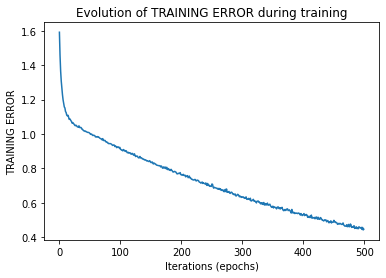

In [ ]:
plt.title("Evolution of TRAINING ERROR during training")
plt.xlabel("Iterations (epochs)")
plt.ylabel("TRAINING ERROR")
plt.plot(Classifier_MLP_hog_500.loss_curve_)
plt.show()

Running Grid search to identify the best parameters

In [ ]:
random_state = 1
parameter_grid = {
    'hidden_layer_sizes': [(50, 100),(100, 150),(100,100)],
    'solver': ['adam'],
    'learning_rate_init':[0.0001, 0.001, 0.01]
}

grid_mlp = GridSearchCV(MLPClassifier(random_state=1, max_iter=100), parameter_grid, n_jobs=-1, verbose = 3)
 
# fitting the model for grid search
%time grid_mlp.fit(hog_features, y_train)
best_mlp = grid_mlp.best_params_
print(best_mlp)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 1min 32s, sys: 19.8 s, total: 1min 52s
Wall time: 9min 54s
{'hidden_layer_sizes': (100, 150), 'learning_rate_init': 0.0001, 'solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


The best parameters as per grid search of MLP - 'hidden_layer_sizes': (100, 150), 'learning_rate_init': 0.0001, 'solver': 'adam'

In [ ]:
Classifier_MLP_grid = MLPClassifier(random_state=1, max_iter=100, hidden_layer_sizes = (100, 150),
                           solver = 'adam', learning_rate_init = 0.0001, early_stopping = True )
%time Classifier_MLP_grid.fit(hog_features, y_train)

CPU times: user 29.5 s, sys: 13.3 s, total: 42.8 s
Wall time: 22.9 s


MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 150),
              learning_rate_init=0.0001, max_iter=100, random_state=1)

In [ ]:
scores_mlp_grid = cross_val_score(Classifier_MLP_grid,hog_features, y_train, cv=5)
scores_mlp_grid

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


array([0.5885947 , 0.62713936, 0.60309698, 0.56316218, 0.54726976])

Seems like this model is overfitted

In [ ]:
scores_mlp_grid.mean()

0.5858526002685669

**TESTING**

In [ ]:
# Create empty lists for feature descriptors and labels
hog_images_test = []
hog_features_test = []
ppc = 16

for image in range(len(X_test)):
    
    img = img_as_ubyte(color.rgb2gray(X_test[image]))
    fd, hog_images = hog( img, orientations=8, pixels_per_cell=(ppc, ppc),  cells_per_block=(1, 1), visualize=True)
    
    hog_images_test.append(hog_images)
    hog_features_test.append(fd)

In [ ]:
print(len(X_test))

3068


In [ ]:
y_Pred_HM = Classifier_MLP_hog.predict(hog_features_test).tolist()

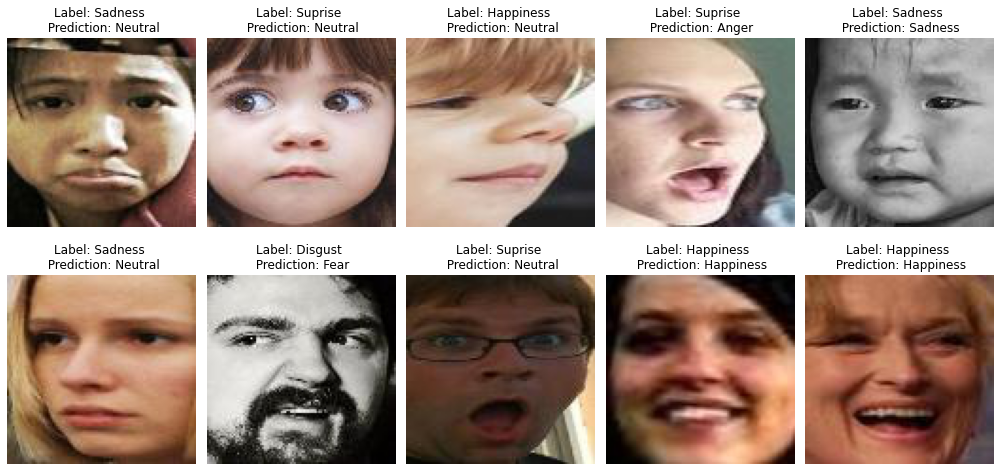

In [ ]:
#Reference - Lab 7
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_Pred_HM[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
print(f"""Classification report for HOG+MLP:
      {metrics.classification_report(y_test, y_Pred_HM)}\n""")

Classification report for HOG+MLP:
                    precision    recall  f1-score   support

       Anger       0.52      0.37      0.43       162
     Disgust       0.23      0.07      0.11       160
        Fear       0.56      0.27      0.36        74
   Happiness       0.75      0.83      0.79      1185
     Neutral       0.53      0.66      0.59       680
     Sadness       0.46      0.53      0.49       478
     Suprise       0.70      0.34      0.46       329

    accuracy                           0.62      3068
   macro avg       0.54      0.44      0.46      3068
weighted avg       0.61      0.62      0.60      3068




In [ ]:
with open ('Model_HOG_MLP.pickle', 'wb') as f:
    pickle.dump(Classifier_MLP_hog, f)

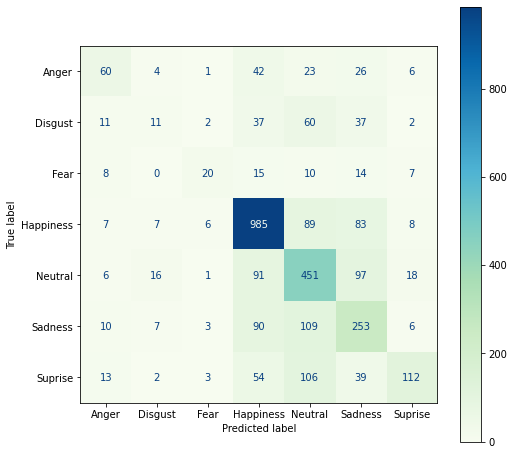

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8, 8))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_Pred_HM, cmap = 'GnBu', ax=ax)
plt.show()

**HOG+SVM**

In [ ]:
classifier_svm_hog = SVC(class_weight= 'balanced') # class_weight is used to handle the class imbalance

# We learn the digits on the first half of the digits
classifier_svm_hog.fit(hog_features, y_train)

SVC(class_weight='balanced')

In [ ]:
classifier_svm_hog.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
scores_svm_hog = cross_val_score(classifier_svm_hog,hog_features, y_train, cv=5)
scores_svm_hog

array([0.59511202, 0.61572942, 0.61572942, 0.56519967, 0.56112469])

In [ ]:
scores_svm_hog.mean()

0.5905790454754447

In [ ]:
classifier_svm_hog1 = SVC(kernel = 'rbf', C = 100, gamma = 1,class_weight= 'balanced') # class_weight is used to handle the class imbalance

# We learn the digits on the first half of the digits
classifier_svm_hog1.fit(hog_features, y_train)

SVC(C=100, class_weight='balanced', gamma=1)

In [ ]:
scores_svm_hog1 = cross_val_score(classifier_svm_hog1,hog_features, y_train, cv=5)
scores_svm_hog1

array([0.5197556 , 0.5191524 , 0.52485738, 0.49796251, 0.50366748])

In [ ]:
classifier_svm_hog2 = SVC(C = 10, gamma = 0.001,class_weight= 'balanced') # class_weight is used to handle the class imbalance

# We learn the digits on the first half of the digits
classifier_svm_hog2.fit(hog_features, y_train)

SVC(C=10, class_weight='balanced', gamma=0.001)

In [ ]:
scores_svm_hog2 = cross_val_score(classifier_svm_hog2,hog_features, y_train, cv=5)
scores_svm_hog2

array([0.52057026, 0.53137734, 0.53137734, 0.48573757, 0.4800326 ])

In [ ]:

random_state = 1 
param_grid_HS = {'C': [0.1,1,10,100], 'gamma': [0.0001,0.001, 0.1,1] }
grid_2 = GridSearchCV(SVC(), param_grid_HS, refit = True, verbose = 3)
 
# fitting the model for grid search
%time grid_2.fit(hog_features, y_train)
best_parameters = grid_2.best_params_
print(best_parameters)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...............C=0.1, gamma=0.0001;, score=0.389 total time=  28.6s
[CV 2/5] END ...............C=0.1, gamma=0.0001;, score=0.389 total time=  30.6s
[CV 3/5] END ...............C=0.1, gamma=0.0001;, score=0.389 total time=  29.6s
[CV 4/5] END ...............C=0.1, gamma=0.0001;, score=0.389 total time=  29.7s
[CV 5/5] END ...............C=0.1, gamma=0.0001;, score=0.389 total time=  29.7s
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.389 total time=  31.0s
[CV 2/5] END ................C=0.1, gamma=0.001;, score=0.389 total time=  31.3s
[CV 3/5] END ................C=0.1, gamma=0.001;, score=0.389 total time=  30.8s
[CV 4/5] END ................C=0.1, gamma=0.001;, score=0.389 total time=  31.5s
[CV 5/5] END ................C=0.1, gamma=0.001;, score=0.389 total time=  32.3s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.541 total time=  30.9s
[CV 2/5] END ..................C=0.1, gamma=0.1;

In [ ]:
classifier_svm_hog3 = SVC(C = 1, gamma = 0.01,class_weight= 'balanced') # class_weight is used to handle the class imbalance

# We learn the digits on the first half of the digits
classifier_svm_hog3.fit(hog_features, y_train)

SVC(C=1, class_weight='balanced', gamma=0.01)

In [ ]:
scores_svm_hog3 = cross_val_score(classifier_svm_hog3,hog_features, y_train, cv=5)
scores_svm_hog3

array([0.52138493, 0.52974735, 0.53178484, 0.48288509, 0.4808476 ])

In [ ]:
y_Pred_HS = classifier_svm_hog.predict(hog_features_test).tolist()

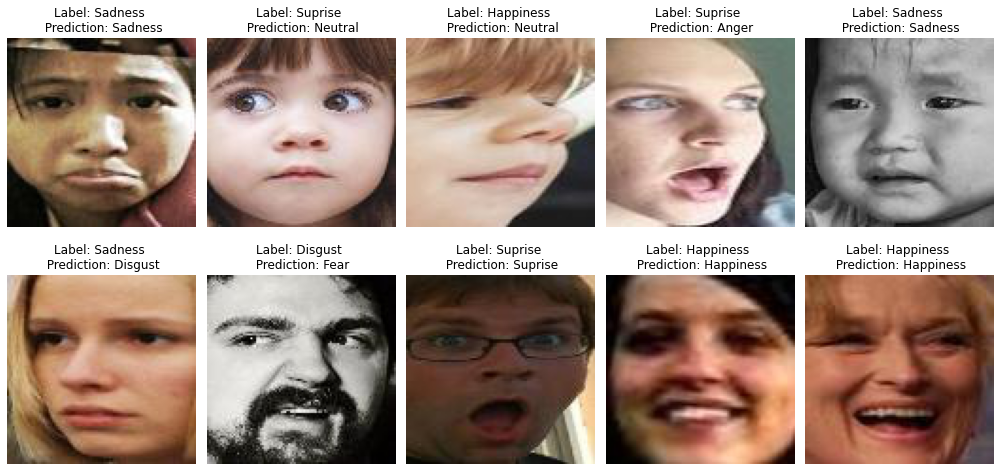

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_Pred_HS[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
print(f"""Classification report for HOG+SVM:
      {metrics.classification_report(y_test, y_Pred_HS)}\n""")

Classification report for HOG+SVM:
                    precision    recall  f1-score   support

       Anger       0.38      0.55      0.45       162
     Disgust       0.21      0.29      0.24       160
        Fear       0.37      0.34      0.35        74
   Happiness       0.84      0.73      0.78      1185
     Neutral       0.61      0.59      0.60       680
     Sadness       0.51      0.51      0.51       478
     Suprise       0.52      0.61      0.56       329

    accuracy                           0.61      3068
   macro avg       0.49      0.52      0.50      3068
weighted avg       0.64      0.61      0.62      3068




In [ ]:
with open ('Model_HOG_SVM.pickle', 'wb') as f:
    pickle.dump(classifier_svm_hog, f)

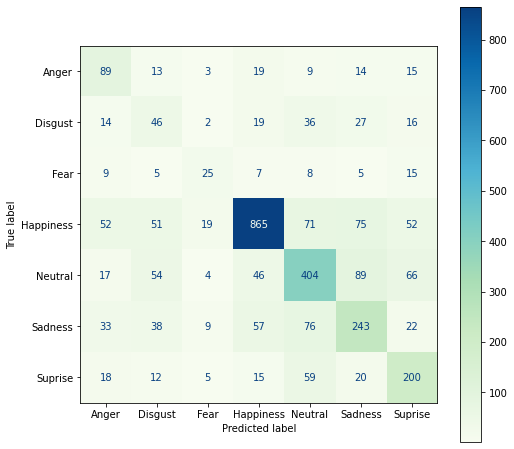

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8, 8))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_Pred_HS, cmap = 'GnBu', ax=ax)
plt.show()